# Finetuning ImageNet Pretrained Model on BloodMNIST

In this notebook, we finetuned the ImageNet pretrained ResNet18 on BloodMNIST dataset. The pre-trained model should be trained on ImageNet with supervision. We compared two types of finetuning pipeline:

1. Finetune the last linear layer with backbone freezed (which is also linear-probing)
2. Finetune the backbone + last linear layer

We also implemented the Classification Activation Map to provide a visualization comparison between different finetuning pipelines.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import resnet18

from data import get_bloodmnist_loader
from utils import *

!nvidia-smi

/h/lkcai/anaconda3/envs/video_comp_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fri Nov 29 05:20:51 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:30:00.0 Off |                    0 |
| N/A   58C    P8    18W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
num_classes = 8
train_loader = get_bloodmnist_loader(split='train', batch_size=64, shuffle=True)
val_loader = get_bloodmnist_loader(split='val', batch_size=100, shuffle=False)
test_loader = get_bloodmnist_loader(split='test', batch_size=100, shuffle=False)

Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz


# Only finetune the final linear layer

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=True)
for name, param in model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()

model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = optim.SGD(parameters, 0.001, momentum=0.9, weight_decay=1e-4)

model = model.to(device)

val_acc = validate(model, val_loader, device)
print(f"Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with Random head - Val Acc: 7.89% 


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 1/50]: Train Loss: 1.3038 Train Acc: 60.16% | Val Acc: 68.81%


100%|██████████| 187/187 [00:40<00:00,  4.61it/s]


[Epoch 2/50]: Train Loss: 0.8439 Train Acc: 76.31% | Val Acc: 74.30%


100%|██████████| 187/187 [00:40<00:00,  4.57it/s]


[Epoch 3/50]: Train Loss: 0.7218 Train Acc: 79.06% | Val Acc: 77.69%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 4/50]: Train Loss: 0.6520 Train Acc: 80.20% | Val Acc: 78.21%


100%|██████████| 187/187 [00:41<00:00,  4.56it/s]


[Epoch 5/50]: Train Loss: 0.6162 Train Acc: 81.50% | Val Acc: 81.13%


100%|██████████| 187/187 [00:41<00:00,  4.53it/s]


[Epoch 6/50]: Train Loss: 0.6030 Train Acc: 80.71% | Val Acc: 83.64%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 7/50]: Train Loss: 0.5734 Train Acc: 81.82% | Val Acc: 83.12%


100%|██████████| 187/187 [00:41<00:00,  4.56it/s]


[Epoch 8/50]: Train Loss: 0.5530 Train Acc: 82.21% | Val Acc: 84.23%


100%|██████████| 187/187 [00:40<00:00,  4.56it/s]


[Epoch 9/50]: Train Loss: 0.5473 Train Acc: 82.38% | Val Acc: 85.16%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 10/50]: Train Loss: 0.5367 Train Acc: 82.63% | Val Acc: 83.47%


100%|██████████| 187/187 [00:40<00:00,  4.57it/s]


[Epoch 11/50]: Train Loss: 0.5294 Train Acc: 82.88% | Val Acc: 84.17%


100%|██████████| 187/187 [00:40<00:00,  4.57it/s]


[Epoch 12/50]: Train Loss: 0.5222 Train Acc: 82.92% | Val Acc: 83.76%


100%|██████████| 187/187 [00:40<00:00,  4.56it/s]


[Epoch 13/50]: Train Loss: 0.5193 Train Acc: 82.85% | Val Acc: 84.58%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 14/50]: Train Loss: 0.5052 Train Acc: 83.74% | Val Acc: 85.75%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 15/50]: Train Loss: 0.5024 Train Acc: 83.65% | Val Acc: 85.46%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 16/50]: Train Loss: 0.4985 Train Acc: 83.62% | Val Acc: 84.35%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 17/50]: Train Loss: 0.4937 Train Acc: 83.22% | Val Acc: 83.18%


100%|██████████| 187/187 [00:40<00:00,  4.57it/s]


[Epoch 18/50]: Train Loss: 0.4933 Train Acc: 83.87% | Val Acc: 85.75%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 19/50]: Train Loss: 0.4915 Train Acc: 83.82% | Val Acc: 84.87%


100%|██████████| 187/187 [00:41<00:00,  4.53it/s]


[Epoch 20/50]: Train Loss: 0.4782 Train Acc: 84.46% | Val Acc: 85.16%


100%|██████████| 187/187 [00:41<00:00,  4.56it/s]


[Epoch 21/50]: Train Loss: 0.4921 Train Acc: 83.85% | Val Acc: 85.34%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 22/50]: Train Loss: 0.4817 Train Acc: 83.84% | Val Acc: 84.70%


100%|██████████| 187/187 [00:40<00:00,  4.56it/s]


[Epoch 23/50]: Train Loss: 0.4671 Train Acc: 84.44% | Val Acc: 85.57%


100%|██████████| 187/187 [00:40<00:00,  4.56it/s]


[Epoch 24/50]: Train Loss: 0.4681 Train Acc: 84.99% | Val Acc: 85.57%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 25/50]: Train Loss: 0.4773 Train Acc: 84.05% | Val Acc: 86.16%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 26/50]: Train Loss: 0.4701 Train Acc: 84.20% | Val Acc: 84.23%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 27/50]: Train Loss: 0.4704 Train Acc: 84.61% | Val Acc: 85.69%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 28/50]: Train Loss: 0.4738 Train Acc: 84.25% | Val Acc: 85.16%


100%|██████████| 187/187 [00:41<00:00,  4.56it/s]


[Epoch 29/50]: Train Loss: 0.4714 Train Acc: 84.38% | Val Acc: 87.03%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 30/50]: Train Loss: 0.4622 Train Acc: 84.45% | Val Acc: 86.57%


100%|██████████| 187/187 [00:40<00:00,  4.56it/s]


[Epoch 31/50]: Train Loss: 0.4585 Train Acc: 84.64% | Val Acc: 84.05%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 32/50]: Train Loss: 0.4658 Train Acc: 84.53% | Val Acc: 85.69%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 33/50]: Train Loss: 0.4709 Train Acc: 84.06% | Val Acc: 85.57%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 34/50]: Train Loss: 0.4633 Train Acc: 84.47% | Val Acc: 83.88%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 35/50]: Train Loss: 0.4546 Train Acc: 84.65% | Val Acc: 84.93%


100%|██████████| 187/187 [00:40<00:00,  4.57it/s]


[Epoch 36/50]: Train Loss: 0.4580 Train Acc: 84.81% | Val Acc: 86.51%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 37/50]: Train Loss: 0.4659 Train Acc: 84.21% | Val Acc: 85.86%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 38/50]: Train Loss: 0.4631 Train Acc: 84.23% | Val Acc: 84.99%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 39/50]: Train Loss: 0.4500 Train Acc: 84.43% | Val Acc: 84.99%


100%|██████████| 187/187 [00:41<00:00,  4.53it/s]


[Epoch 40/50]: Train Loss: 0.4502 Train Acc: 84.75% | Val Acc: 84.35%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 41/50]: Train Loss: 0.4508 Train Acc: 84.66% | Val Acc: 85.34%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 42/50]: Train Loss: 0.4518 Train Acc: 84.97% | Val Acc: 86.68%


100%|██████████| 187/187 [00:41<00:00,  4.56it/s]


[Epoch 43/50]: Train Loss: 0.4502 Train Acc: 85.02% | Val Acc: 84.81%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 44/50]: Train Loss: 0.4496 Train Acc: 84.69% | Val Acc: 86.04%


100%|██████████| 187/187 [00:40<00:00,  4.56it/s]


[Epoch 45/50]: Train Loss: 0.4467 Train Acc: 84.48% | Val Acc: 86.92%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 46/50]: Train Loss: 0.4415 Train Acc: 85.26% | Val Acc: 86.27%


100%|██████████| 187/187 [00:41<00:00,  4.56it/s]


[Epoch 47/50]: Train Loss: 0.4368 Train Acc: 85.34% | Val Acc: 85.81%


100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


[Epoch 48/50]: Train Loss: 0.4444 Train Acc: 85.02% | Val Acc: 84.93%


100%|██████████| 187/187 [00:41<00:00,  4.55it/s]


[Epoch 49/50]: Train Loss: 0.4395 Train Acc: 85.09% | Val Acc: 86.45%


100%|██████████| 187/187 [00:40<00:00,  4.59it/s]


[Epoch 50/50]: Train Loss: 0.4453 Train Acc: 84.91% | Val Acc: 85.86%


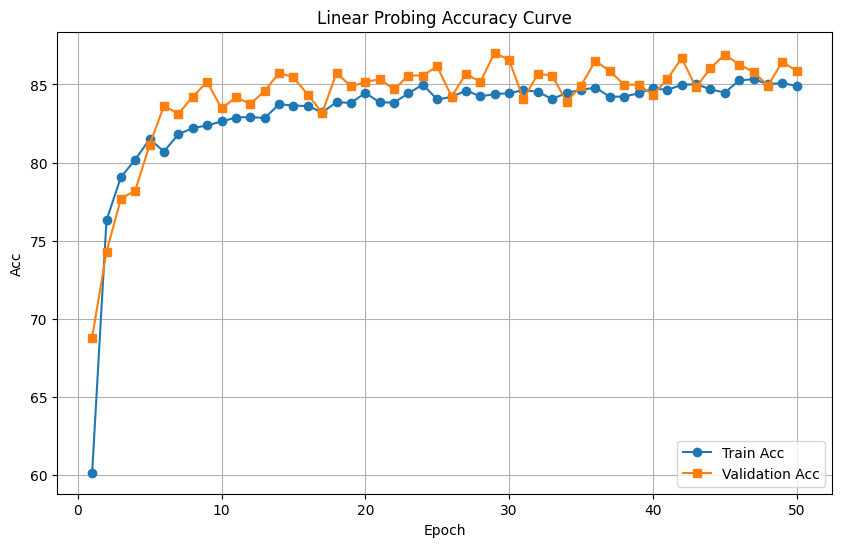

In [15]:
num_epochs = 50

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()

In [16]:
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_ft_head_res18_{num_epochs}e.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

In [17]:
save_path = "/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_ft_head_res18_50e.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 8)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

model.load_state_dict(torch.load(save_path)['model_state_dict'])
model = model.to(device)

val_acc = validate(model, val_loader, device)
print(f"ResNet18 without pretraining - Val Acc: {val_acc:.2f}% ")

test_acc = validate(model, test_loader, device)
print(f"ResNet18 without pretraining - Test Acc: {test_acc:.2f}% ")

ResNet18 without pretraining - Val Acc: 85.86% 
ResNet18 without pretraining - Test Acc: 85.59% 


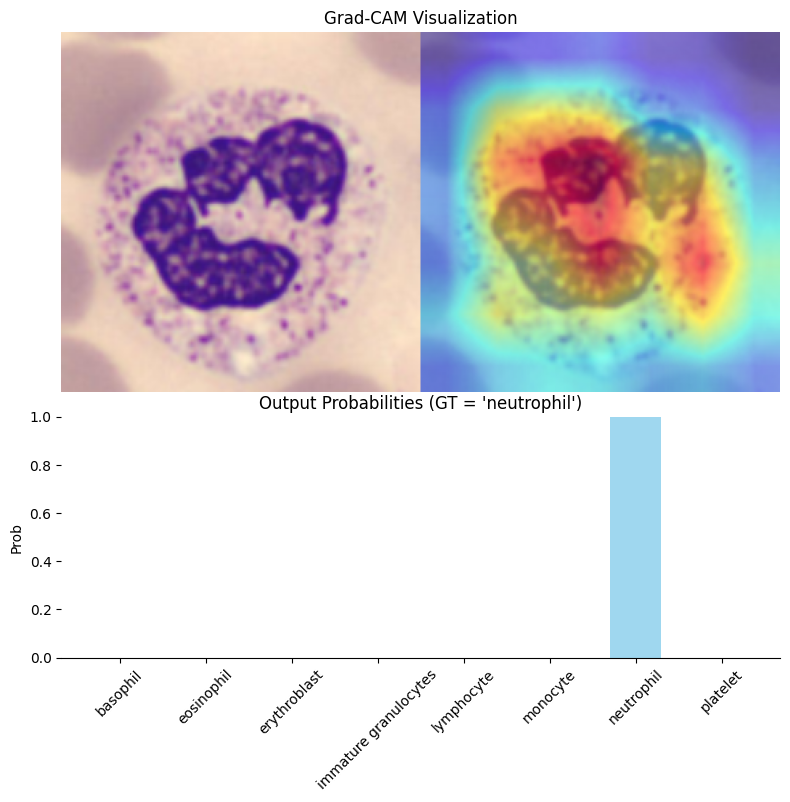

In [12]:
class_names = list(bloodmnist_label.values())

vis_res, output_probs, label = grad_cam_vis(model, val_loader, img_idx=88)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vis_results/cam_vis_head.png')
plt.show()

# Finetune the whole model: backbone + final linear layer

In [8]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), 0.001, momentum=0.9, weight_decay=1e-4)

model = model.to(device)

val_acc = validate(model, val_loader, device)
print(f"Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with Random head - Val Acc: 19.68% 


100%|██████████| 187/187 [00:47<00:00,  3.93it/s]


[Epoch 1/30]: Train Loss: 0.8851 Train Acc: 72.26% | Val Acc: 94.04%


100%|██████████| 187/187 [00:46<00:00,  4.06it/s]


[Epoch 2/30]: Train Loss: 0.3103 Train Acc: 90.35% | Val Acc: 97.25%


100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


[Epoch 3/30]: Train Loss: 0.2301 Train Acc: 92.60% | Val Acc: 97.08%


100%|██████████| 187/187 [00:46<00:00,  4.00it/s]


[Epoch 4/30]: Train Loss: 0.1973 Train Acc: 93.39% | Val Acc: 97.78%


100%|██████████| 187/187 [00:46<00:00,  3.99it/s]


[Epoch 5/30]: Train Loss: 0.1741 Train Acc: 94.04% | Val Acc: 97.84%


100%|██████████| 187/187 [00:46<00:00,  4.01it/s]


[Epoch 6/30]: Train Loss: 0.1602 Train Acc: 94.72% | Val Acc: 98.07%


100%|██████████| 187/187 [00:46<00:00,  4.01it/s]


[Epoch 7/30]: Train Loss: 0.1517 Train Acc: 94.75% | Val Acc: 97.96%


100%|██████████| 187/187 [00:46<00:00,  4.00it/s]


[Epoch 8/30]: Train Loss: 0.1399 Train Acc: 95.34% | Val Acc: 98.36%


100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


[Epoch 9/30]: Train Loss: 0.1335 Train Acc: 95.59% | Val Acc: 98.83%


100%|██████████| 187/187 [00:46<00:00,  3.99it/s]


[Epoch 10/30]: Train Loss: 0.1220 Train Acc: 95.94% | Val Acc: 98.71%


100%|██████████| 187/187 [00:46<00:00,  4.00it/s]


[Epoch 11/30]: Train Loss: 0.1163 Train Acc: 96.09% | Val Acc: 98.60%


100%|██████████| 187/187 [00:46<00:00,  4.03it/s]


[Epoch 12/30]: Train Loss: 0.1126 Train Acc: 96.40% | Val Acc: 98.60%


100%|██████████| 187/187 [00:46<00:00,  3.99it/s]


[Epoch 13/30]: Train Loss: 0.1148 Train Acc: 96.23% | Val Acc: 98.95%


100%|██████████| 187/187 [00:46<00:00,  4.00it/s]


[Epoch 14/30]: Train Loss: 0.1089 Train Acc: 96.50% | Val Acc: 98.42%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 15/30]: Train Loss: 0.1050 Train Acc: 96.55% | Val Acc: 98.89%


100%|██████████| 187/187 [00:46<00:00,  3.99it/s]


[Epoch 16/30]: Train Loss: 0.0991 Train Acc: 96.55% | Val Acc: 98.77%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 17/30]: Train Loss: 0.0986 Train Acc: 96.63% | Val Acc: 99.01%


100%|██████████| 187/187 [00:46<00:00,  4.00it/s]


[Epoch 18/30]: Train Loss: 0.0981 Train Acc: 96.76% | Val Acc: 98.77%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 19/30]: Train Loss: 0.0980 Train Acc: 96.71% | Val Acc: 98.83%


100%|██████████| 187/187 [00:46<00:00,  4.00it/s]


[Epoch 20/30]: Train Loss: 0.0933 Train Acc: 96.78% | Val Acc: 98.89%


100%|██████████| 187/187 [00:47<00:00,  3.97it/s]


[Epoch 21/30]: Train Loss: 0.0890 Train Acc: 97.12% | Val Acc: 99.01%


100%|██████████| 187/187 [00:47<00:00,  3.97it/s]


[Epoch 22/30]: Train Loss: 0.0940 Train Acc: 97.03% | Val Acc: 98.95%


100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


[Epoch 23/30]: Train Loss: 0.0831 Train Acc: 97.26% | Val Acc: 98.89%


100%|██████████| 187/187 [00:46<00:00,  4.01it/s]


[Epoch 24/30]: Train Loss: 0.0810 Train Acc: 97.27% | Val Acc: 98.95%


100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


[Epoch 25/30]: Train Loss: 0.0878 Train Acc: 97.10% | Val Acc: 98.95%


100%|██████████| 187/187 [00:46<00:00,  4.03it/s]


[Epoch 26/30]: Train Loss: 0.0849 Train Acc: 97.17% | Val Acc: 98.89%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 27/30]: Train Loss: 0.0789 Train Acc: 97.43% | Val Acc: 98.95%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 28/30]: Train Loss: 0.0792 Train Acc: 97.31% | Val Acc: 99.01%


100%|██████████| 187/187 [00:46<00:00,  4.01it/s]


[Epoch 29/30]: Train Loss: 0.0833 Train Acc: 97.15% | Val Acc: 98.83%


100%|██████████| 187/187 [00:46<00:00,  3.98it/s]


[Epoch 30/30]: Train Loss: 0.0819 Train Acc: 97.24% | Val Acc: 99.01%


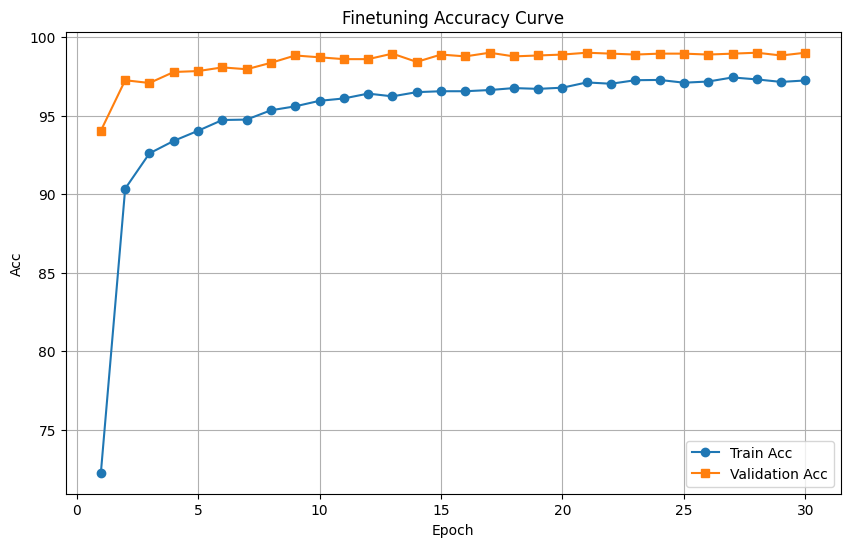

In [9]:
num_epochs = 30

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Finetuning Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()

In [10]:
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_ft_all_res18_{num_epochs}e.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

In [11]:
save_path = "/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_ft_all_res18_30e.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 8)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

model.load_state_dict(torch.load(save_path)['model_state_dict'])
model = model.to(device)

val_acc = validate(model, val_loader, device)
print(f"ResNet18 with ImageNet pretraining - Val Acc: {val_acc:.2f}% ")

test_acc = validate(model, test_loader, device)
print(f"ResNet18 with ImageNet pretraining - Test Acc: {test_acc:.2f}% ")

ResNet18 with ImageNet pretraining - Val Acc: 99.01% 
ResNet18 with ImageNet pretraining - Test Acc: 98.80% 


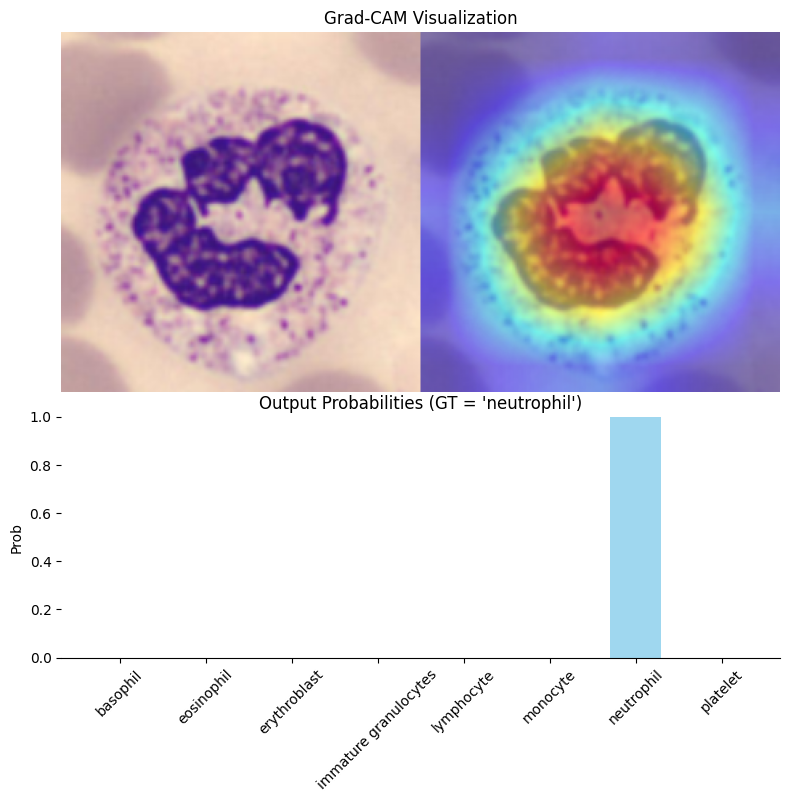

In [15]:
imgs, labels = next(iter(val_loader))

for param in model.parameters():
    param.requires_grad = True

idx = 88
target_layers = [model.layer4[-1]]
input_tensor = imgs[idx].unsqueeze(0)
rgb_img = imgs[idx].permute(1, 2, 0)
rgb_img = img_denormalize(rgb_img).numpy()
label = labels[idx].item()

targets = [ClassifierOutputTarget(label)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    model_outputs = cam.outputs

vis_res = np.concatenate([rgb_img, visualization / 255], axis=1)

output_probs = model_outputs.squeeze().softmax(dim=0).detach().cpu().numpy()
class_names = list(bloodmnist_label.values())

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

# Plot the Grad-CAM visualization
axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

# Plot the bar chart
axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the figure
plt.tight_layout()
plt.savefig('vis_results/cam_vis_all.png')
plt.show()